In [1]:
# import modules
import os
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import gseapy as gp
from gseapy.plot import gseaplot
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
# specify working directory
os.chdir('/Volumes/Passport/CSDB/brain_scRNAseq/')

In [3]:
# load in data
adata = sc.read_h5ad('all_internship/data/processed/raw_merged_barcode_filtered.h5ad')

In [4]:
# Retrieve required information
counts = adata.X
samples = adata.obs['Sample']

# Identify unique sample names
unique_samples = np.unique(samples)

# Create new AnnData object
aggregated_adata = ad.AnnData(X=np.zeros((len(unique_samples), counts.shape[1])),
                             var=adata.var)

# Aggregate counts
for i, sample in enumerate(unique_samples):
    sample_counts = counts[samples == sample].sum(axis=0)
    aggregated_adata.X[i] = sample_counts

# Update the count matrix
aggregated_adata.obs['sample'] = unique_samples

aggregated_adata.obs.index = aggregated_adata.obs['sample']
aggregated_adata

AnnData object with n_obs × n_vars = 16 × 15872
    obs: 'sample'

In [5]:
# Retrieve the required information
counts = aggregated_adata.X
features = aggregated_adata.var_names
samples = aggregated_adata.obs_names

# Create the pandas DataFrame
aggregated_counts = pd.DataFrame(counts, index=samples, columns=features)

aggregated_counts

,0610007P14Rik,0610009B22Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610010K14Rik;Gm21988,0610011F06Rik,0610012G03Rik,0610030E20Rik,...,SRV-MM-int:ERVK:LTR,X2-LINE:CR1:LINE,X3-LINE:RTE-BovB:LINE,X5B-LINE:CR1:LINE,X6A-LINE:CR1:LINE,X6B-LINE:CR1:LINE,X7A-LINE:CR1:LINE,X7B-LINE:CR1:LINE,X7C-LINE:CR1:LINE,X8-LINE:CR1:LINE
sample,,,,,,,,,,,,,,,,,,,,,
OX1X,669.0,370.0,125.0,212.0,82.0,215.0,589.0,344.0,997.0,292.0,...,39.0,16.0,33.0,23.0,9.0,40.0,29.0,83.0,27.0,82.0
OX2X,420.0,264.0,80.0,138.0,55.0,183.0,427.0,221.0,658.0,197.0,...,20.0,17.0,24.0,13.0,14.0,37.0,25.0,75.0,7.0,52.0
OX3X,1862.0,933.0,459.0,487.0,157.0,712.0,1496.0,979.0,2255.0,614.0,...,58.0,41.0,94.0,57.0,46.0,152.0,47.0,222.0,42.0,173.0
OX4X,2199.0,982.0,422.0,551.0,202.0,711.0,1536.0,1057.0,2246.0,574.0,...,58.0,25.0,82.0,55.0,32.0,109.0,40.0,160.0,42.0,168.0
OX5X,911.0,475.0,168.0,198.0,87.0,273.0,644.0,351.0,1029.0,296.0,...,25.0,15.0,24.0,26.0,15.0,61.0,31.0,111.0,15.0,67.0
OX6X,1070.0,559.0,214.0,291.0,128.0,399.0,813.0,468.0,1327.0,355.0,...,26.0,53.0,54.0,33.0,22.0,104.0,66.0,208.0,5.0,104.0
OX7X,771.0,391.0,180.0,167.0,70.0,342.0,622.0,383.0,859.0,280.0,...,24.0,13.0,39.0,33.0,18.0,67.0,30.0,72.0,14.0,74.0
OX8X,1048.0,450.0,246.0,230.0,95.0,431.0,765.0,499.0,1136.0,302.0,...,25.0,15.0,58.0,48.0,26.0,95.0,28.0,87.0,12.0,109.0
YX1L,619.0,260.0,95.0,143.0,61.0,280.0,468.0,239.0,671.0,198.0,...,28.0,10.0,37.0,26.0,10.0,48.0,21.0,73.0,8.0,75.0


In [7]:
metadata = pd.DataFrame(zip(aggregated_counts.index, ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y', 'Y']),
                        columns = ['sample', 'condition']) 
metadata = metadata.set_index('sample')
metadata

,condition
sample,
OX1X,O
OX2X,O
OX3X,O
OX4X,O
OX5X,O
OX6X,O
OX7X,O
OX8X,O
YX1L,Y


In [10]:
# create dds object
dds = DeseqDataSet(counts=aggregated_counts,
            clinical=metadata,
            design_factors="condition")

In [11]:
# run deseq2
dds.deseq2()

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 3.45 seconds.

Fitting dispersion trend curve...
... done in 4.44 seconds.

Fitting MAP dispersions...
... done in 4.43 seconds.

Fitting LFCs...
... done in 2.10 seconds.

Refitting 10 outliers.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



In [12]:
# fetch results for 'up'
stat_res = DeseqStats(dds, n_cpus = 10, contrast = ('condition', 'O', 'Y'))
stat_res.summary()

Running Wald tests...
... done in 1.43 seconds.

Log2 fold change & Wald test p-value: condition O vs Y


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0610007P14Rik,975.049532,-0.269570,0.081401,-3.311652,0.000927,0.030104
0610009B22Rik,478.078403,-0.185962,0.074986,-2.479945,0.013140,0.132085
0610009L18Rik,192.415652,-0.100278,0.135533,-0.739883,0.459371,0.747579
0610009O20Rik,243.907401,-0.207557,0.078500,-2.644046,0.008192,0.102706
0610010F05Rik,90.980213,-0.045219,0.113807,-0.397332,0.691123,0.879527
...,...,...,...,...,...,...
X6B-LINE:CR1:LINE,62.525483,0.279312,0.158447,1.762811,0.077932,0.327277
X7A-LINE:CR1:LINE,27.270875,0.572988,0.242792,2.359998,0.018275,0.157070
X7B-LINE:CR1:LINE,92.582207,0.424183,0.182158,2.328654,0.019877,0.163038
X7C-LINE:CR1:LINE,15.412944,0.116588,0.315363,0.369694,0.711611,0.889625


In [13]:
# fetch results
stat_res = DeseqStats(dds, n_cpus = 10, contrast = ('condition', 'O', 'Y'))
stat_res.summary()

Running Wald tests...
... done in 1.12 seconds.

Log2 fold change & Wald test p-value: condition O vs Y


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0610007P14Rik,975.049532,-0.269570,0.081401,-3.311652,0.000927,0.030104
0610009B22Rik,478.078403,-0.185962,0.074986,-2.479945,0.013140,0.132085
0610009L18Rik,192.415652,-0.100278,0.135533,-0.739883,0.459371,0.747579
0610009O20Rik,243.907401,-0.207557,0.078500,-2.644046,0.008192,0.102706
0610010F05Rik,90.980213,-0.045219,0.113807,-0.397332,0.691123,0.879527
...,...,...,...,...,...,...
X6B-LINE:CR1:LINE,62.525483,0.279312,0.158447,1.762811,0.077932,0.327277
X7A-LINE:CR1:LINE,27.270875,0.572988,0.242792,2.359998,0.018275,0.157070
X7B-LINE:CR1:LINE,92.582207,0.424183,0.182158,2.328654,0.019877,0.163038
X7C-LINE:CR1:LINE,15.412944,0.116588,0.315363,0.369694,0.711611,0.889625


In [14]:
# get data frame
res = stat_res.results_df
res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0610007P14Rik,975.049532,-0.269570,0.081401,-3.311652,0.000927,0.030104
0610009B22Rik,478.078403,-0.185962,0.074986,-2.479945,0.013140,0.132085
0610009L18Rik,192.415652,-0.100278,0.135533,-0.739883,0.459371,0.747579
0610009O20Rik,243.907401,-0.207557,0.078500,-2.644046,0.008192,0.102706
0610010F05Rik,90.980213,-0.045219,0.113807,-0.397332,0.691123,0.879527
...,...,...,...,...,...,...
X6B-LINE:CR1:LINE,62.525483,0.279312,0.158447,1.762811,0.077932,0.327277
X7A-LINE:CR1:LINE,27.270875,0.572988,0.242792,2.359998,0.018275,0.157070
X7B-LINE:CR1:LINE,92.582207,0.424183,0.182158,2.328654,0.019877,0.163038
X7C-LINE:CR1:LINE,15.412944,0.116588,0.315363,0.369694,0.711611,0.889625


In [15]:
# filter out genes with a basemean less than 10
res = res[res.baseMean >= 10]
res

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0610007P14Rik,975.049532,-0.269570,0.081401,-3.311652,0.000927,0.030104
0610009B22Rik,478.078403,-0.185962,0.074986,-2.479945,0.013140,0.132085
0610009L18Rik,192.415652,-0.100278,0.135533,-0.739883,0.459371,0.747579
0610009O20Rik,243.907401,-0.207557,0.078500,-2.644046,0.008192,0.102706
0610010F05Rik,90.980213,-0.045219,0.113807,-0.397332,0.691123,0.879527
...,...,...,...,...,...,...
X6B-LINE:CR1:LINE,62.525483,0.279312,0.158447,1.762811,0.077932,0.327277
X7A-LINE:CR1:LINE,27.270875,0.572988,0.242792,2.359998,0.018275,0.157070
X7B-LINE:CR1:LINE,92.582207,0.424183,0.182158,2.328654,0.019877,0.163038
X7C-LINE:CR1:LINE,15.412944,0.116588,0.315363,0.369694,0.711611,0.889625


In [16]:
res.index

Index(['0610007P14Rik', '0610009B22Rik', '0610009L18Rik', '0610009O20Rik',
       '0610010F05Rik', '0610010K14Rik', '0610010K14Rik;Gm21988',
       '0610011F06Rik', '0610012G03Rik', '0610030E20Rik',
       ...
       'SRV-MM-int:ERVK:LTR', 'X2-LINE:CR1:LINE', 'X3-LINE:RTE-BovB:LINE',
       'X5B-LINE:CR1:LINE', 'X6A-LINE:CR1:LINE', 'X6B-LINE:CR1:LINE',
       'X7A-LINE:CR1:LINE', 'X7B-LINE:CR1:LINE', 'X7C-LINE:CR1:LINE',
       'X8-LINE:CR1:LINE'],
      dtype='object', length=15262)

In [17]:
# filter significants
sigs = res[(res.padj < 0.05)]
sigs

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0610007P14Rik,975.049532,-0.269570,0.081401,-3.311652,0.000927,0.030104
1110008F13Rik,903.227182,-0.210970,0.063214,-3.337410,0.000846,0.028589
1110046J04Rik,110.193692,0.282509,0.091371,3.091895,0.001989,0.047540
1500009C09Rik,281.527282,-0.301190,0.088636,-3.398049,0.000679,0.025051
1810058I24Rik,911.475706,-0.236363,0.066520,-3.553291,0.000380,0.016962
...,...,...,...,...,...,...
RMER13A:ERVK:LTR,379.310073,0.634729,0.185511,3.421512,0.000623,0.024000
RMER4B:ERVK:LTR,2573.473373,0.240468,0.070607,3.405706,0.000660,0.024530
RMER5:ERV1:LTR,2833.222010,0.170210,0.043243,3.936145,0.000083,0.006101
RMER6A:ERVK:LTR,3418.241919,0.374007,0.095846,3.902173,0.000095,0.006671


In [19]:
LINEs = [feature for feature in res.index if feature.endswith('LINE')]
LTRs = [feature for feature in res.index if feature.endswith('LTR')]

In [20]:
# get SenMayo and aging brain genes
SenMayo = pd.read_csv('Final/Utilities/out/SenMayo_genes.csv')
SenMayo = [gene for gene in SenMayo['x']]
brain_aging = pd.read_csv('all_internship/data/other/aging_sets/brain_genes_up.csv')
brain_aging = [gene for gene in brain_aging]
gene_sets = {'SenMayo':SenMayo, 'Aging brain':brain_aging, 'LINEs':LINEs, 'LTRs':LTRs}
gene_sets

{'SenMayo': ['Apod',
  'Fcgr2b',
  'C3',
  'Clu',
  'Ctss',
  'Lyz2',
  'Jchain',
  'C1qa',
  'S100a6',
  'Gfap',
  'C1qb',
  'Lgals3',
  'Mgst1',
  'Anxa3',
  'Anxa5',
  'S100a4',
  'Gpnmb',
  'C1qc',
  'Vwf',
  'Derl1',
  'Ndrg1',
  'Fcgr3',
  'Gbp2',
  'Gns',
  'Il33',
  'Mpeg1',
  'Npc2',
  'Adipor2',
  'B2m',
  'Litaf',
  'Serping1',
  'Hcst',
  'Rnf213',
  'Spp1',
  'Clic4',
  'Efemp1',
  'Laptm5',
  'Vat1',
  'Efcab14',
  'Ptges3',
  'Rasa3',
  'Psmd11',
  'Sgk1',
  'Txnip',
  'H2-M3',
  'Pcsk6',
  'Tmed10',
  'Msn',
  'C1ra',
  'Csrp1',
  'Grn',
  'H2-Ea-ps',
  'Gltp',
  'Tyrobp',
  'Dtx3l',
  'Cd74',
  'Ctsh',
  'Fn1',
  'Hspa1a',
  'S100a10',
  'Sdc4',
  'Limch1',
  'Riok3',
  'Rnaset2b',
  'Sort1',
  'Arl11',
  'Ehd3',
  'Hmgb2',
  'P2ry12',
  'C1s1',
  'Col18a1',
  'Mcl1',
  'Akap13',
  'Hmgcll1',
  'Itgb8',
  'Trf',
  'Fam107a',
  'Ahnak',
  'Cdkn1a',
  'Trib3',
  'H2-DMb1',
  'Pus7',
  'Aspa',
  'Dnajb2',
  'Fermt3',
  'Gm7030',
  'Sac3d1',
  'Sh3glb1',
  'Arf6',
  'Pkp4'

In [21]:
# rank genes
ranking = res[['stat']].dropna().sort_values('stat', ascending = False)
ranking

,stat
Bhlhe41,8.115330
Serpina3n,6.956047
Klk8,6.790187
C4b,6.491175
Naalad2,6.258838
...,...
2210011C24Rik,-6.555006
Tmem163,-7.002015
Rnd2,-7.245879
Marcksl1,-7.336087


In [39]:
# create prerank
pre_res = gp.prerank(rnk = ranking,
                    gene_sets = gene_sets,
                    seed = 6,
                    permutation_num = 1000,
                    permutation_type = 'phenotype')
pre_res

2023-07-16 22:14:45,503 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [23]:
# create data frame with fdr, es and nes
out = []

for term in list(pre_res.results):
    out.append([term,
               pre_res.results[term]['fdr'],
               pre_res.results[term]['es'],
               pre_res.results[term]['nes']])

out_df = pd.DataFrame(out, columns = ['Term','fdr', 'es', 'nes']).sort_values('fdr').reset_index(drop = True)
out_df

,Term,fdr,es,nes
0,Aging brain,0.0,0.355176,1.658713
1,LTRs,0.0,0.613999,3.355885
2,LINEs,0.0,0.728309,3.418563
3,SenMayo,0.0,0.477306,2.311035


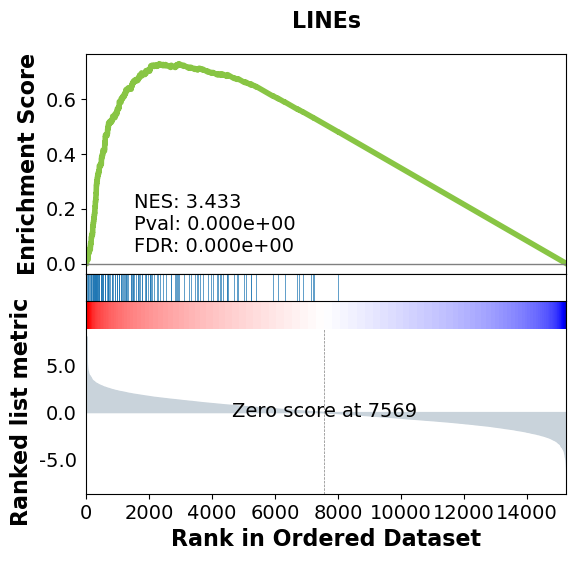

In [40]:
# plot GSEA for LINEs
gseaplot(pre_res.ranking,
         term = 'LINEs',
         **pre_res.results['LINEs'])

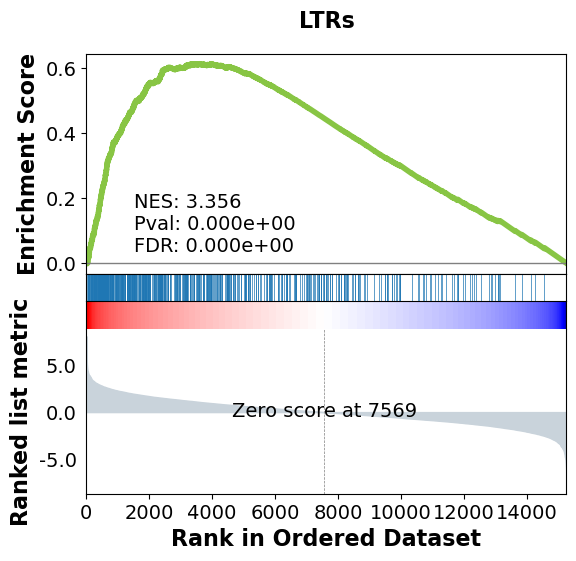

In [43]:
# plot GSEA for LTRs
gseaplot(pre_res.ranking,
         term = 'LTRs',
         **pre_res.results['LTRs'])

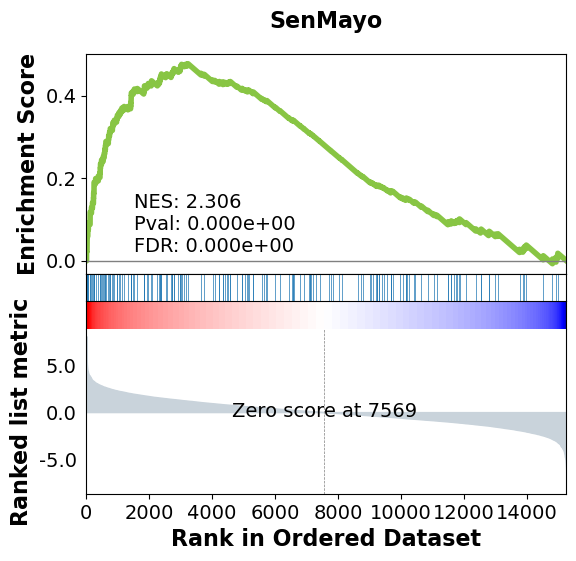

In [41]:
# plot GSEA for SenMayo genes
gseaplot(pre_res.ranking,
         term = 'SenMayo',
         **pre_res.results['SenMayo'])

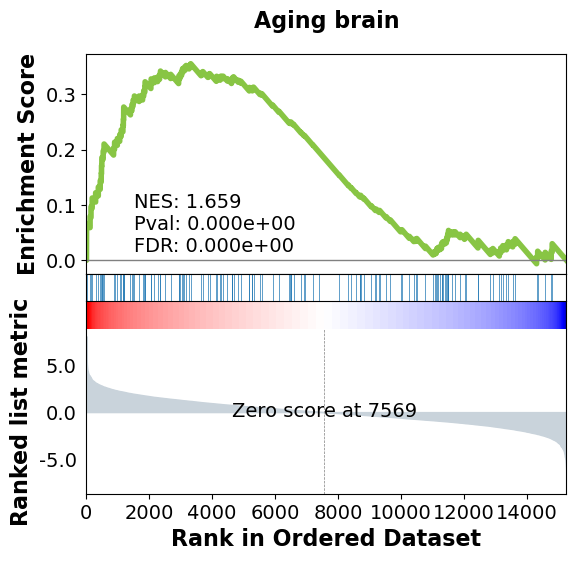

In [54]:
# plot GSEA for aging brain gene set
gseaplot(pre_res.ranking,
         term = 'Aging brain',
         **pre_res.results['Aging brain'])

In [43]:
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])
dds.layers['log1p']

array([[6.60700525, 6.01581525, 4.9353967 , ..., 4.52955408, 3.4286737 ,
        4.51756424],
       [6.50615665, 6.0427336 , 4.85425889, ..., 4.79023991, 2.49629888,
        4.42766456],
       [6.82608955, 6.13616815, 5.42904456, ..., 4.70734452, 3.08030142,
        4.46051274],
       ...,
       [6.99543568, 6.20123284, 5.27901903, ..., 4.46946014, 2.75441581,
        4.24355943],
       [7.01894154, 6.38730754, 5.48064799, ..., 4.20658761, 2.7193257 ,
        4.20658761],
       [7.02692714, 6.32052903, 5.37117434, ..., 4.35218956, 3.2252902 ,
        4.26244356]])

In [55]:
SenMayo_sigs = sigs[sigs.index.isin(SenMayo)].index
brain_aging_sigs = sigs[sigs.index.isin(brain_aging)].index

In [60]:
dds.var_names = adata.var_names

In [61]:
dds_sub_LINEs = dds[:, sigs[sigs.index.isin(LINEs)].index]
dds_sub_LTRs = dds[:, sigs[sigs.index.isin(LTRs)].index]

In [62]:
dds_sub_SenMayo = dds[:, sigs[sigs.index.isin(SenMayo)].index]
dds_sub_brain_aging = dds[:, sigs[sigs.index.isin(brain_aging)].index]

In [63]:
grapher_LINEs = pd.DataFrame(dds_sub_LINEs.layers['log1p'].T,
                       index=dds_sub_LINEs.var_names, columns=dds_sub_LINEs.obs_names)

In [64]:
grapher_LTRs = pd.DataFrame(dds_sub_LTRs.layers['log1p'].T,
                       index=dds_sub_LTRs.var_names, columns=dds_sub_LTRs.obs_names)

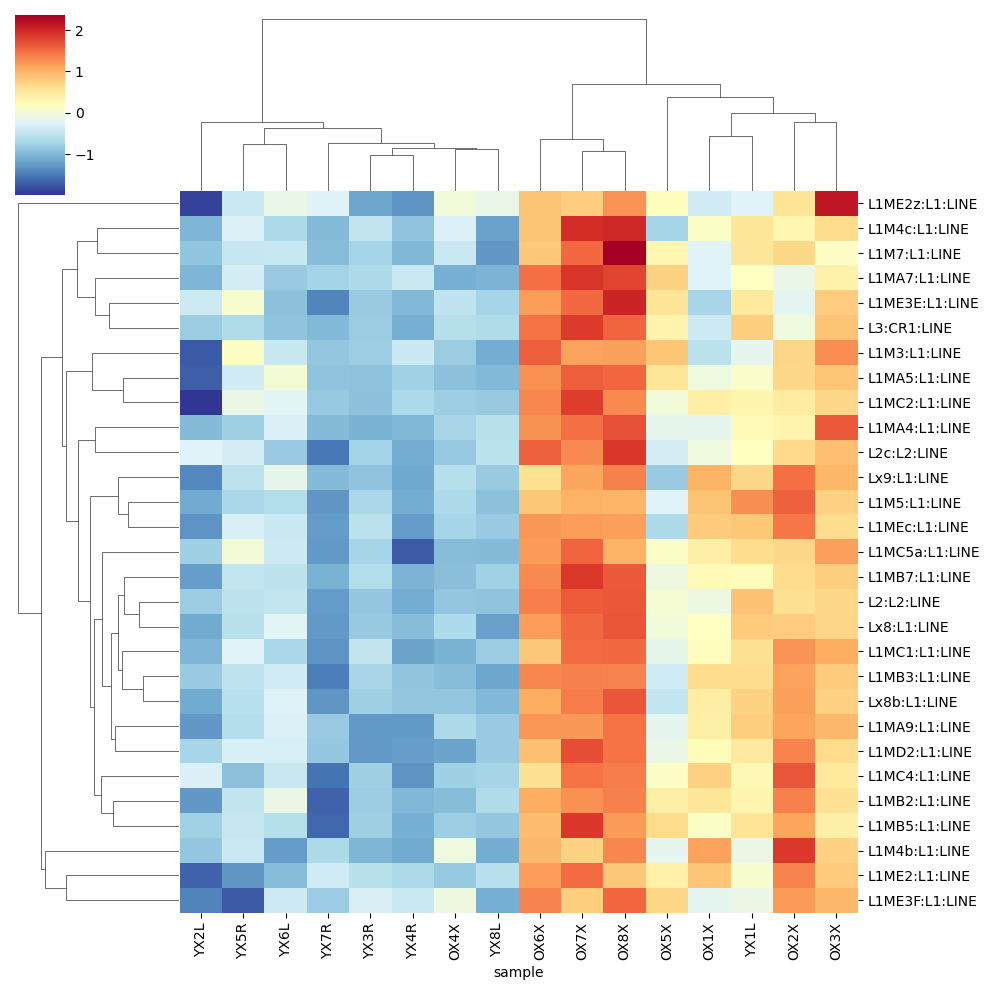

In [65]:
sns.clustermap(grapher_LINEs, z_score=0, cmap = 'RdYlBu_r')

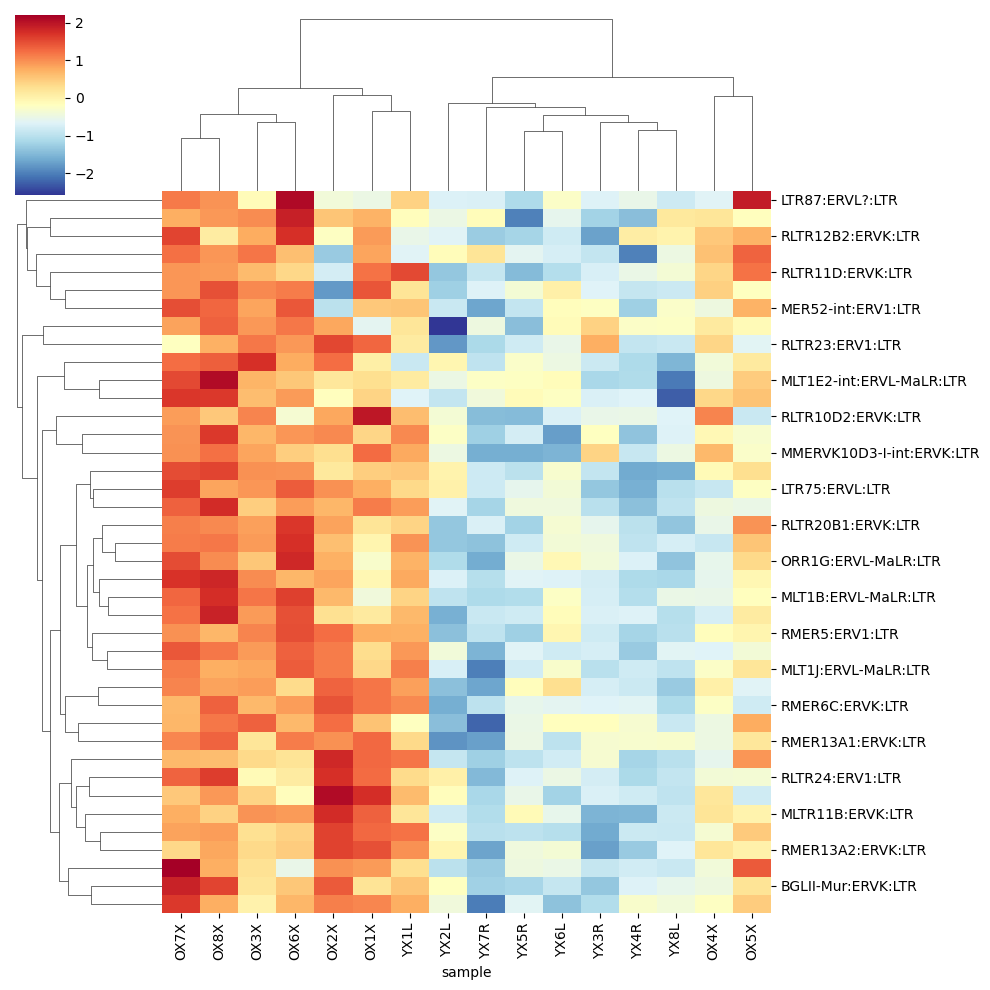

In [66]:
sns.clustermap(grapher_LTRs, z_score=0, cmap = 'RdYlBu_r')

In [67]:
grapher_SenMayo = pd.DataFrame(dds_sub_SenMayo.layers['log1p'].T,
                       index=dds_sub_SenMayo.var_names, columns=dds_sub_SenMayo.obs_names)

In [68]:
grapher_SenMayo = pd.DataFrame(dds_sub_SenMayo.layers['log1p'].T,
                       index=dds_sub_SenMayo.var_names, columns=dds_sub_SenMayo.obs_names)

In [69]:
grapher_brain_aging = pd.DataFrame(dds_sub_brain_aging.layers['log1p'].T,
                       index=dds_sub_brain_aging.var_names, columns=dds_sub_brain_aging.obs_names)

In [90]:
old = []
young = []
for i in range(1,9):
    old.append('old ' + str(i))
    young.append('young ' + str(i))
colnames = old + young

grapher_SenMayo.columns = colnames
grapher_SenMayo

,old 1,old 2,old 3,old 4,old 5,old 6,old 7,old 8,young 1,young 2,young 3,young 4,young 5,young 6,young 7,young 8
Anxa3,6.751318,6.702005,6.598783,6.541198,6.707657,6.447632,6.723394,6.690313,6.373210,6.525317,6.440604,6.190877,6.510872,6.060582,6.515448,6.529423
Anxa4,4.752924,4.408481,4.449020,4.534655,4.737374,4.394771,4.662011,4.801799,4.462135,4.458111,4.302478,4.129920,4.276269,4.108054,4.133625,4.444373
B2m,8.835219,8.907012,8.868775,8.814137,8.926181,8.747466,8.678041,8.698514,8.664107,8.898653,8.422857,8.366366,8.408654,8.187738,8.639937,8.643469
C3,2.984947,3.333924,2.005156,3.876003,3.788649,3.289959,3.237294,2.962736,2.126510,2.796449,2.144712,1.836339,2.303809,1.775622,1.564167,1.791560
Clec10a,2.286477,2.729135,2.592272,2.584895,2.665170,3.258410,1.502957,2.049090,2.428316,3.458607,3.439082,2.822603,3.003255,3.239453,3.241087,3.289414
Cp,5.533176,5.374326,5.343023,5.028372,5.389255,5.170808,5.653389,5.263731,5.050475,5.208604,4.997360,4.920397,5.008647,4.900728,5.221497,5.198259
Ctsh,6.989364,7.146050,6.936212,6.876508,7.041084,6.877794,6.973662,6.939748,6.783138,6.913050,6.782050,6.655779,6.756254,6.418387,6.786896,6.917631
Ctsz,7.656248,7.644955,7.770097,7.812967,7.774382,7.695098,7.835127,7.896534,7.644744,7.706266,7.447168,7.435976,7.379587,7.251626,7.601810,7.625030
Il33,7.851304,7.683044,8.170188,8.309645,8.227824,8.146987,8.220755,8.212204,8.211200,7.785499,7.665494,7.815836,7.553334,7.710348,7.776310,7.704723
Olig2,6.466177,5.926663,6.847847,6.736948,6.736143,6.786102,6.617077,6.636048,6.786479,6.891959,6.992057,6.992465,7.064086,6.937168,7.012156,6.823409


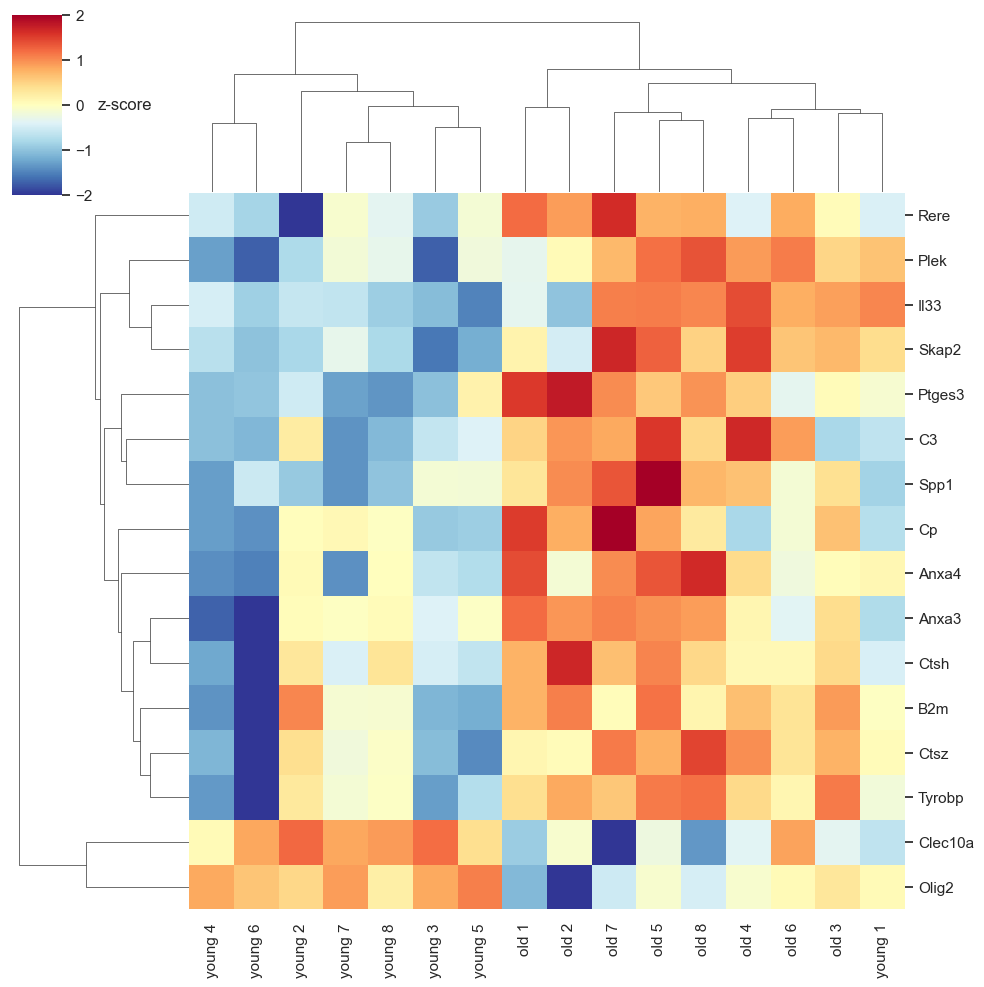

In [144]:
sns.set(font='Arial')

plot = sns.clustermap(grapher_SenMayo, z_score=0, cmap = 'RdYlBu_r', vmin = -2, vmax = 2)

colorbar = plot.ax_heatmap.collections[0].colorbar

colorbar.set_label('z-score')
colorbar.ax.get_yaxis().label.set_rotation(0)
colorbar.ax.yaxis.set_label_coords(2.25, 0.54)

plt.savefig('all_internship/figures/report/GSEA/heatmap_SenMayo.png', dpi = 300)

plt.show()

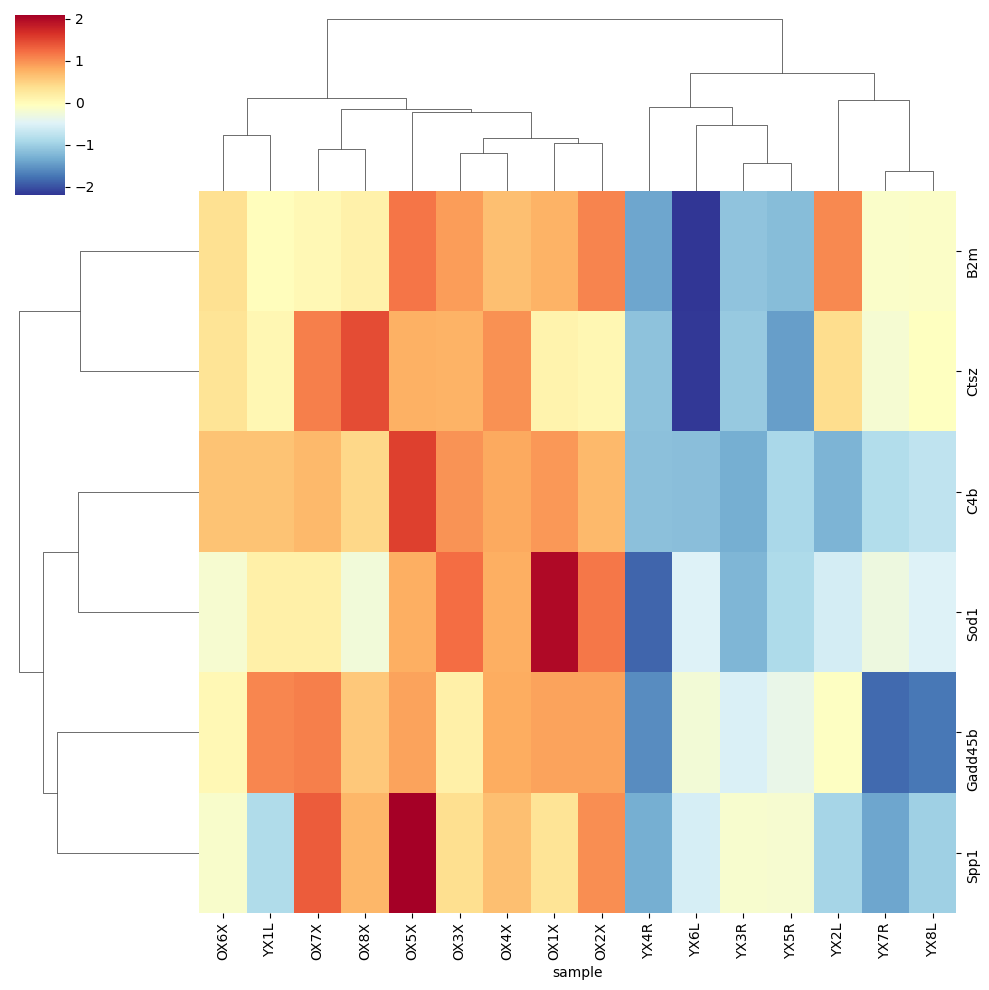

In [81]:
sns.clustermap(grapher_brain_aging, z_score=0, cmap = 'RdYlBu_r')

In [151]:
# create dataframes for LINEs and LTRs with Log2FoldChange descending
res_LINEs = res[res.index.isin(LINEs)].sort_values('log2FoldChange', ascending = False)
res_LTRs = res[res.index.isin(LTRs)].sort_values('log2FoldChange', ascending = False)

res_LINEs

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
L1M8:L1:LINE,36.280642,0.903794,0.337038,2.681576,0.007328,0.097280
L4-C-Mam:RTE-X:LINE,1369.138744,0.669234,0.238123,2.810450,0.004947,0.077977
L1MEg1:L1:LINE,21.953197,0.650970,0.287830,2.261649,0.023719,0.179357
L1ME5:L1:LINE,13.295621,0.635566,0.339834,1.870224,0.061453,0.289515
Mam-R4:Dong-R4:LINE,63.207477,0.598290,0.222328,2.691023,0.007123,0.095978
...,...,...,...,...,...,...
L1-Mus1:L1:LINE,93351.854769,0.019022,0.116537,0.163230,0.870337,0.956163
L1Md-A:L1:LINE,43270.231897,0.014344,0.162068,0.088504,0.929476,0.976091
L1Md-F3:L1:LINE,42710.827645,0.012020,0.144329,0.083286,0.933624,0.977512
L1ME3D:L1:LINE,181.783682,0.011920,0.112851,0.105631,0.915875,0.972013


In [152]:
# only keep significant ones
res_LINEs_sig = res_LINEs[res_LINEs['padj'] <= 0.05]

In [153]:
# keep only subfamily name
rownames = res_LINEs_sig.index
new_rownames = []
for row in rownames:
    row = row.split(':')[0]
    new_rownames.append(row)
new_rownames
res_LINEs_sig.index = new_rownames
res_LINEs_sig

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
L1ME3E,118.905507,0.513396,0.165247,3.106838,1.891001e-03,0.046535
L1M4b,964.707371,0.456011,0.079499,5.736027,9.692321e-09,0.000007
L1M7,159.859176,0.454457,0.133657,3.400175,6.734274e-04,0.024915
L1ME3F,156.248519,0.356137,0.084722,4.203601,2.627023e-05,0.003021
L1MB5,2495.458846,0.304417,0.080535,3.779932,1.568710e-04,0.009222
L1MC2,1336.836388,0.286879,0.085377,3.360157,7.789812e-04,0.027114
L1MC4,4094.273060,0.269289,0.068184,3.949422,7.834025e-05,0.005990
L1M4c,1543.191791,0.260210,0.083768,3.106318,1.894330e-03,0.046543
L1MA7,1927.376915,0.259079,0.084325,3.072395,2.123482e-03,0.049562
L1MA5,1955.793797,0.254042,0.070646,3.595987,3.231638e-04,0.014824


In [154]:
# only keep significant ones
res_LTRs_sig = res_LTRs[res_LTRs['padj'] <= 0.05]

In [155]:
# only keep subfamily names
rownames = res_LTRs_sig.index
new_rownames = []
for row in rownames:
    row = row.split(':')[0]
    new_rownames.append(row)
new_rownames
res_LTRs_sig.index = new_rownames
res_LTRs_sig

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
MER52-int,16.100263,1.283985,0.362162,3.545333,0.000392,0.017336
RLTR10D2,294.050362,0.884780,0.233244,3.793362,0.000149,0.008948
ERVB4-1C-LTR-Mm,68.745283,0.830167,0.271020,3.063127,0.002190,0.049903
LTR87,54.257479,0.812390,0.258923,3.137579,0.001703,0.043836
LTR85c,23.347430,0.777956,0.209981,3.704884,0.000211,0.011115
MER76,36.145411,0.761612,0.179840,4.234933,0.000023,0.002728
MLT1E2-int,28.567392,0.713905,0.218486,3.267513,0.001085,0.032892
BGLII-Mur,137.874572,0.690751,0.173807,3.974248,0.000071,0.005717
RMER13A,379.310073,0.634729,0.185511,3.421512,0.000623,0.024000
LTR48,50.550647,0.586442,0.172121,3.407156,0.000656,0.024529


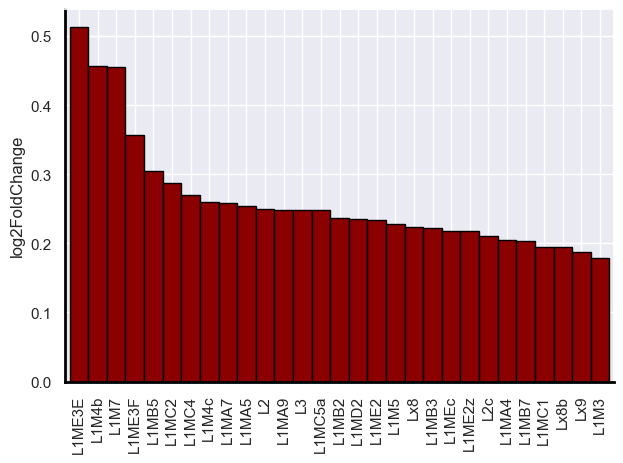

In [182]:
# make bar graph of log2foldchanges
import matplotlib.font_manager as fm

# Set the row names as the index
res_LINEs_sig.set_index(res_LINEs_sig.index, inplace=True)

# Create the figure and axes
fig, ax = plt.subplots()

# Create the histogram
bar_width = 1  # Adjust the width of the bars as needed
res_LINEs_sig['log2FoldChange'].plot(kind='bar', ax=ax, color='darkred', edgecolor='black', width=bar_width)

# Set the x-axis label
#ax.set_xlabel('LINE subfamilies', fontname='Arial')

# Set the y-axis label
ax.set_ylabel('log2FoldChange', fontname='Arial')

# Set the font for tick labels
plt.xticks(fontname='Arial')
plt.yticks(fontname='Arial')

# Set the axis spines
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

# Set the linewidth of the axis spines
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

# Find the path of the Arial font file
font_path = fm.findfont(fm.FontProperties(family='Arial'))
plt.tight_layout()


# Save the figure with a white background and transparent foreground
plt.savefig('all_internship/figures/report/GSEA/log2foldchange_LINE.png', facecolor='white', transparent=True)

# Show the plot
plt.show()

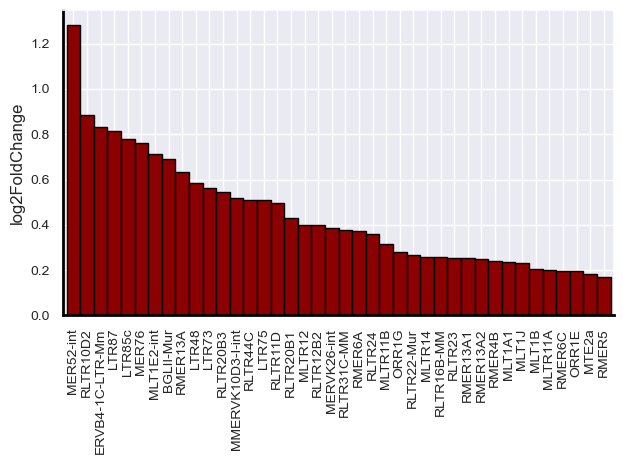

In [188]:
# make bar graph of log2foldchanges

# Set the row names as the index
res_LTRs_sig.set_index(res_LTRs_sig.index, inplace=True)

# Create the figure and axes
fig, ax = plt.subplots()

# Create the histogram
bar_width = 1  # Adjust the width of the bars as needed
res_LTRs_sig['log2FoldChange'].plot(kind='bar', ax=ax, color='darkred', edgecolor='black', width=bar_width)

# Set the y-axis label
ax.set_ylabel('log2FoldChange', fontname='Arial')

# Set the font for tick labels
plt.xticks(fontname='Arial', fontsize = 10)
plt.yticks(fontname='Arial', fontsize = 10)

# Set the axis spines
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

# Set the linewidth of the axis spines
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

# Find the path of the Arial font file
font_path = fm.findfont(fm.FontProperties(family='Arial'))

plt.tight_layout()


# Save the figure with a white background and transparent foreground
plt.savefig('all_internship/figures/report/GSEA/log2foldchange_LTR.png', facecolor='white', transparent=True)

# Show the plot
plt.show()